# Mental Illness Detection Using NLP

#Business Case

As the use of social media grows everyday, the need for a tool to perform mental health analysis on text posted online grows too. A tool that can interpret text to screen for distressed mental health signals indicating issues like stress, anxiety, depression, etc., could help with multiple scanarios such as background checks. So we aim to build a model that can dectect sentiment within text to detect various types of mental health issues based on what people post online. We tested this through various reddit posts.

##Data Collection
The dataset we worked with to train and test this model was made up of 3 different datasets; 2 from HuggingFace and 1 from Kaggle. The data was made of +500K instances of Reddit posts which were labeled with various mental health cases. Origiinally, 1 dataset was cleaned with good puntucation and grammar with no special characters. The other 2 datasets needed to be cleaned of special characters and also consisted of modern texting slang. We used the ftfy module to remove any special characters and punctuation from the combined dataset but unfortunately the model had to learn on slang.

# FINE-TUNING TRANSFORMER MODELS TO DETECT MENTAL ILLNESS IN REDDIT POSTS
To investigate whether we can detect signs of mental illness through Reddit posts, we fine-tuned several transformer models on a balanced, labeled dataset. We started with DistilBERT as a lightweight baseline to validate our pipeline and gain initial performance benchmarks. While fast, its performance plateaued quickly — prompting a shift to more powerful models like RoBERTa for deeper experimentation.

In [ ]:
! pip install --upgrade transformers
! pip install evaluate
! pip install datasets
! pip install transformers datasets evaluate seqeval transformers[torch]
! pip install -q transformers ftfy torch torchvision torchaudio accelerate

import os
import torch
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from itertools import product

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
# SEEDING

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# LOADING AND CLEANING DATASET

In [ ]:
# LOAD DATASET AND CLEANING IT

import ftfy
from google.colab import drive
drive.mount('/content/drive')

df1 = pd.read_excel("/content/drive/MyDrive/MSBX 5425 NLP/NLP COMBINED DATA.xlsx")
df2 = pd.read_excel("/content/drive/MyDrive/MSBX 5425 NLP/NLP COMBINED DATA - 2.xlsx")

# Dropping unnamed columns
drop_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Key', 'Unnamed: 7']
df1.drop(columns=drop_cols, inplace=True)
df2.drop(columns=drop_cols, inplace=True)

# Dropping missing values
df1.dropna(subset=['clean_text'], inplace=True)
df2.dropna(subset=['clean_text'], inplace=True)

# Mapping labels to diagnosis names
label_map = {
    0: 'stress',
    1: 'depression',
    2: 'bipolar',
    3: 'BPD',
    4: 'anxiety',
    5: 'other'
}
df1['condition'] = df1['diagnosis'].map(label_map)
df2['condition'] = df2['diagnosis'].map(label_map)

# Merging Datasets
df = pd.concat([df1, df2], axis=0)
df['clean_text'] = df['clean_text'].astype(str).apply(ftfy.fix_text)

df['label'] = df['diagnosis']

# Seeing number of post
df['condition'].value_counts()

Mounted at /content/drive


,count
condition,
BPD,212766
anxiety,161623
depression,125025
other,49813
bipolar,35626
stress,3900


# MAKING BALANCED DATASET
Before training, we created a balanced dataset by sampling an equal number of examples (1,000) from each class. This was done to avoiding model bias, for fair evaluation, and stable training.

Additionally, due to compute constraints such as memory crashes from full BERT runs, this sampling also made the training feasible.

In [ ]:
# MAKING BALANCED DATASET

samples_per_class = 1000

df = (
    df[df["label"].isin([0, 1, 2, 3, 4, 5])]
    .groupby("label")
    .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
    .reset_index(drop=True)
)
print("Sample counts per label:\n", df["label"].value_counts())

Sample counts per label:
 label
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
Name: count, dtype: int64


<ipython-input-5-d7b904b65f0d>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=42))


# DistilBERT served as a fast baseline to validate the pipeline
DistilBERT was used as a baseline due to its speed and efficiency. It’s a lighter version of BERT, making it ideal for quickly testing and validating the pipeline without heavy resource use. While it performed decently (~7% accuracy), it mainly served as a starting point before switching to more powerful models.

To better understand how different training setups impact model performance, we ran a grid search across key hyperparameters — learning rate, batch size, and number of epochs. Specifically, we experimented with 2 learning rates (1e-5, 1e-3), 2 batch sizes (8, 32), and 2 epoch counts (2, 6), totaling 8 combinations. This setup allowed us to explore more drastically different learning rates, which is crucial for identifying impactful trends. By comparing validation loss and F1 scores across these varied configurations, we gained a clearer picture of how these parameters interact, helping us find a training strategy that balances performance and generalization without overfitting or excessive compute use.

Results showed that a lower learning rate of 1e-5 consistently outperformed 1e-3, particularly in terms of F1 score and validation loss. For example, the combination of lr=1e-5, batch=8, epochs=6 yielded the highest F1 (~0.70) and stable loss — indicating strong generalization. In contrast, configurations using lr=1e-3 either plateaued early or failed to learn, especially at smaller batch sizes.

By comparing these configurations, we were able to visualize learning behavior through validation loss curves, spot signs of overfitting, and select a training strategy that strikes a balance between performance and efficiency.

In [ ]:
# TRYING DIFFERENT PARAMETERS

learning_rates = [1e-5, 1e-3]
batch_sizes = [8, 32]
epochs_list = [2, 6]

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]


Training with lr=1e-05, batch=8, epochs=2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-10-69e0463dc548>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.147600,1.093208,0.635833,0.602244,0.642266,0.635833
2,0.972700,0.947281,0.685833,0.677912,0.683294,0.685833


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with lr=1e-05, batch=8, epochs=6


<ipython-input-10-69e0463dc548>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.173600,1.125665,0.615000,0.566321,0.602071,0.615000
2,0.918400,0.870811,0.704167,0.702193,0.701394,0.704167
3,0.763800,0.853449,0.696667,0.689175,0.696171,0.696667
4,0.685100,0.835845,0.698333,0.694237,0.696205,0.698333
5,0.675200,0.846123,0.704167,0.701523,0.700482,0.704167
6,0.574500,0.847097,0.704167,0.701834,0.700338,0.704167


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with lr=1e-05, batch=32, epochs=2


<ipython-input-10-69e0463dc548>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.784700,1.638541,0.412500,0.356454,0.394970,0.412500
2,1.407600,1.341481,0.549167,0.522968,0.539633,0.549167


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with lr=1e-05, batch=32, epochs=6


<ipython-input-10-69e0463dc548>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.781500,1.668103,0.365833,0.312143,0.364948,0.365833
2,1.456000,1.288003,0.580833,0.551590,0.568377,0.580833
3,1.196500,1.018844,0.660000,0.641287,0.655567,0.660000
4,0.935700,0.928168,0.685000,0.673767,0.675818,0.685000
5,0.889200,0.901035,0.694167,0.686508,0.686576,0.694167
6,0.849400,0.893706,0.693333,0.684054,0.684195,0.693333


,learning_rate,batch_size,epochs,accuracy,f1,loss
1,0.00001,8,6,0.704167,0.701834,0.847097
3,0.00001,32,6,0.693333,0.684054,0.893706
0,0.00001,8,2,0.685833,0.677912,0.947281
2,0.00001,32,2,0.549167,0.522968,1.341481


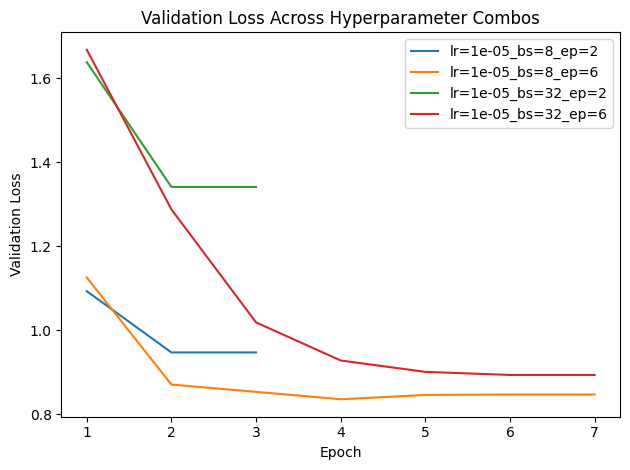

In [ ]:
combos = list(product(learning_rates, batch_sizes, epochs_list))[:4]  # FIRST 4 COMBOS

# Tokenizer & Data
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Loop with Loss Tracking
results = []
val_loss_history = {}

for lr, bs, ep in combos:
    print(f"\nTraining with lr={lr}, batch={bs}, epochs={ep}")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=bs,
        num_train_epochs=ep,
        learning_rate=lr,
        weight_decay=0.01,
        gradient_accumulation_steps=2,
        warmup_steps=100,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        fp16=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_metrics = trainer.evaluate()

    # Save metrics
    results.append({
        "learning_rate": lr,
        "batch_size": bs,
        "epochs": ep,
        "accuracy": eval_metrics["eval_accuracy"],
        "f1": eval_metrics["eval_f1"],
        "loss": eval_metrics["eval_loss"]
    })

    # Save per-epoch val loss
    key = f"lr={lr}_bs={bs}_ep={ep}"
    val_loss_history[key] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Results Table
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
display(results_df)

# Plotting
for key, losses in val_loss_history.items():
    plt.plot(range(1, len(losses)+1), losses, label=key)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Hyperparameter Combos")
plt.legend()
plt.tight_layout()
plt.show()

## Insights from Learning Rate 0.00001
Models trained with a smaller batch size of 8 consistently outperformed those with a batch size of 32 across accuracy, F1, and validation loss.

Increasing training from 2 to 6 epochs significantly improved performance, suggesting the model benefits from longer training to learn patterns, without overfitting.

The best-performing setup was: lr=1e-5, batch_size=8, epochs=6, achieving:
Accuracy: 0.704, F1 Score: 0.701, Validation Loss: 0.847. Validation loss was steady dropping but then plateaus @ 0.85, and both accuracy and F1 remain consistent ~0.70.

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with lr=0.001, batch=8, epochs=2


<ipython-input-11-58b72fbbaa67>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.804600,1.793104,0.166667,0.047619,0.027778,0.166667
2,1.791800,1.791950,0.166667,0.047619,0.027778,0.166667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-58b72fbbaa67>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with lr=0.001, batch=8, epochs=6


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.811700,1.793554,0.166667,0.047619,0.027778,0.166667
2,1.790300,1.791768,0.166667,0.047619,0.027778,0.166667
3,1.791900,1.791764,0.166667,0.047619,0.027778,0.166667
4,1.792500,1.791944,0.166667,0.047619,0.027778,0.166667
5,1.792000,1.791764,0.166667,0.047619,0.027778,0.166667
6,1.791700,1.791762,0.166667,0.047619,0.027778,0.166667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-58b72fbbaa67>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with lr=0.001, batch=32, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.339000,1.313463,0.500833,0.459629,0.480483,0.500833
2,1.311700,1.181046,0.555833,0.520422,0.567121,0.555833



Training with lr=0.001, batch=32, epochs=6


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-58b72fbbaa67>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.344900,1.088099,0.593333,0.578112,0.701162,0.593333
2,1.376000,1.347337,0.440000,0.347854,0.291424,0.440000
3,1.318700,1.364836,0.427500,0.322909,0.277395,0.427500
4,1.329600,1.338223,0.385000,0.299534,0.322324,0.385000
5,1.296900,1.296137,0.417500,0.326988,0.304341,0.417500
6,1.252400,1.278002,0.429167,0.332320,0.302127,0.429167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,learning_rate,batch_size,epochs,accuracy,f1,loss
2,0.001,32,2,0.555833,0.520422,1.181046
3,0.001,32,6,0.429167,0.332320,1.278002
1,0.001,8,6,0.166667,0.047619,1.791762
0,0.001,8,2,0.166667,0.047619,1.791950


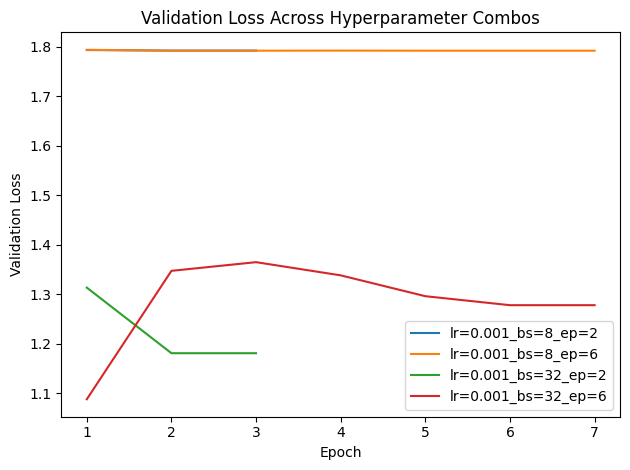

In [ ]:
combos = list(product(learning_rates, batch_sizes, epochs_list))[4:]  # LAST 4 COMBOS

# Tokenizer & Data
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Loop with Loss Tracking
results = []
val_loss_history = {}

for lr, bs, ep in combos:
    print(f"\nTraining with lr={lr}, batch={bs}, epochs={ep}")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=bs,
        num_train_epochs=ep,
        learning_rate=lr,
        weight_decay=0.01,
        gradient_accumulation_steps=2,
        warmup_steps=100,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        fp16=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_metrics = trainer.evaluate()

    # Save metrics
    results.append({
        "learning_rate": lr,
        "batch_size": bs,
        "epochs": ep,
        "accuracy": eval_metrics["eval_accuracy"],
        "f1": eval_metrics["eval_f1"],
        "loss": eval_metrics["eval_loss"]
    })

    # Save per-epoch val loss
    key = f"lr={lr}_bs={bs}_ep={ep}"
    val_loss_history[key] = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Results
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
display(results_df)

# Plotting
for key, losses in val_loss_history.items():
    plt.plot(range(1, len(losses)+1), losses, label=key)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Hyperparameter Combos")
plt.legend()
plt.tight_layout()
plt.show()

## Insights from Learning Rate 0.001
using lr=0.001 proved too aggressive, especially with smaller batch sizes. The best performance came from batch_size=32, epochs=2, but even that fell short of lower learning rate results. A smaller learning rate like 1e-5 seems more stable and effective for this task.

The best-performing setup overall was: lr=1e-5, batch_size=8, epochs=6,

# RoBERTa - balanced, Best well-generalized
After establishing a stable training pipeline and identifying optimal hyperparameters using faster models like DistilBERT, it made sense to scale up to RoBERTa. RoBERTa offers a more robust architecture and handles contextual language more effectively which is an essential trait when classifying nuanced mental health expressions.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

<ipython-input-14-ff2158f4759b>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.917200,0.873169,0.702500,0.698305,0.702187,0.702500
2,0.810500,0.781202,0.724167,0.724889,0.726419,0.724167
3,0.657100,0.796219,0.714167,0.711290,0.712734,0.714167
4,0.585400,0.815686,0.724167,0.725443,0.732685,0.724167
5,0.502000,0.856674,0.722500,0.723365,0.725804,0.722500


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.917200,0.873169,0.702500,0.698305,0.702187,0.702500
2,0.810500,0.781202,0.724167,0.724889,0.726419,0.724167
3,0.657100,0.796219,0.714167,0.711290,0.712734,0.714167
4,0.585400,0.815686,0.724167,0.725443,0.732685,0.724167
5,0.502000,0.856674,0.722500,0.723365,0.725804,0.722500
6,0.435600,0.874878,0.719167,0.719160,0.720355,0.719167


📊 Final Evaluation: {'eval_loss': 0.8748782277107239, 'eval_accuracy': 0.7191666666666666, 'eval_f1': 0.7191601020997688, 'eval_precision': 0.7203548441517827, 'eval_recall': 0.7191666666666667, 'eval_runtime': 17.7217, 'eval_samples_per_second': 67.713, 'eval_steps_per_second': 8.464, 'epoch': 6.0}


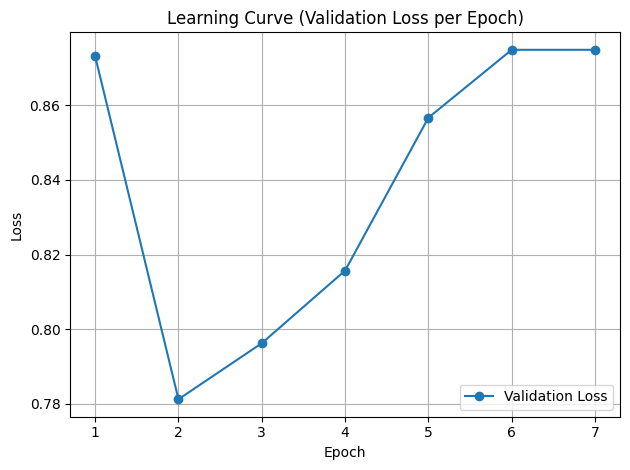

In [ ]:
# USING BEST MODEL PERFORMANCE AND TESTING ON ROBERTA - Training with lr=1e-05, batch=8, epochs=6

# Load Model and Tokenizer
model_name = "roberta-base"  # CHANGED FROM distilbert to roberta
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Tokenize Function
def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

# Prepare Data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=6,
    learning_rate=1e-5,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
    fp16=False,
    report_to="none"
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Final Evaluation
eval_results = trainer.evaluate()
print("📊 Final Evaluation:", eval_results)

# Plot Learning Curve
val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Validation Loss per Epoch)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

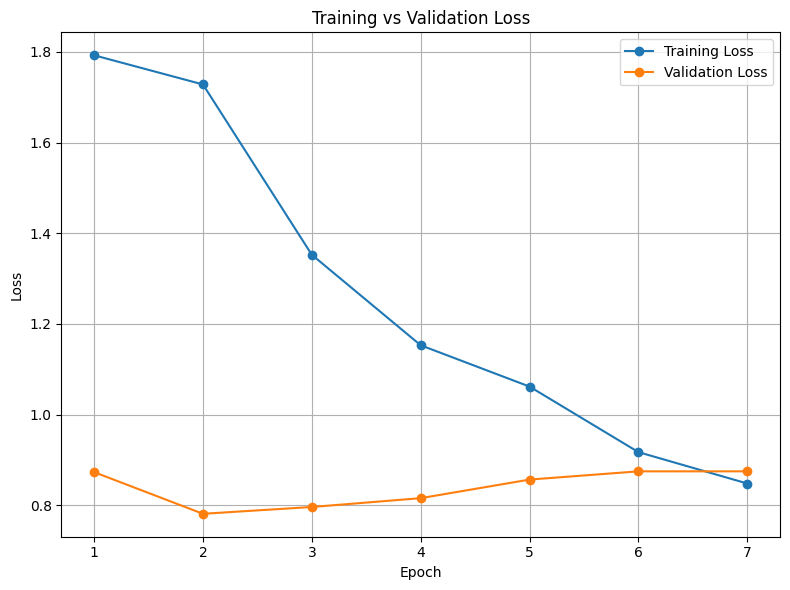

In [ ]:
# Ploting Training vs Validation Loss

train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

epochs = list(range(1, len(val_loss) + 1))

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss[:len(val_loss)], marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Insights
In comparing DistilBERT and RoBERTa under identical training conditions of learning rate of 1e-5, batch size of 8, and 6 epochs, RoBERTa achieved stronger overall performance, with a final F1 score of 0.7192 and accuracy of 71.92%, outperforming DistilBERT’s F1 of 0.7018 and accuracy of 70.42%. While DistilBERT demonstrated more stable validation loss, RoBERTa’s indicate a more effective learning of classes, making it the more suitable model for this task. Based on these results, we will continue training all models through 6 full epochs, using validation metrics to monitor overfitting and identify the best-performing checkpoint.

# TESTING LEARNING RATES
To better understand how sensitive the model was to smaller learning rate changes, we ran a series of controlled experiments with learning rates of 2e-5, 3e-5, and 5e-5, while keeping all other hyperparameters fixed to observe how fine-grained adjustments affected validation stability and generalization. As shown in the plot, 2e-5 consistently delivered the lowest validation loss across epochs and led to the best final performance of F1 0.7323 and Accuracy 73.17%, while 3e-5 performed comparably with only a slight drop-off. The model trained with 5e-5, however, showed higher and less stable validation loss throughout, suggesting it was too aggressive for this dataset.

These findings confirm that smaller learning rates like 2e-5 are better suited for this task and data size, as they allow for more gradual and stable convergence without overshooting optimal weights. As a result, 2e-5 was selected as the default for final model training and evaluation.

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]


Training with learning rate: 2e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-5b95d72caf0e>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.860300,0.816521,0.706667,0.707996,0.711028,0.706667
2,0.734000,0.772364,0.732500,0.732882,0.734551,0.732500
3,0.525000,0.792788,0.731667,0.732272,0.733584,0.731667


Final Evaluation: {'eval_loss': 0.7927883863449097, 'eval_accuracy': 0.7316666666666667, 'eval_f1': 0.7322724139884693, 'eval_precision': 0.7335841880113588, 'eval_recall': 0.7316666666666666, 'eval_runtime': 17.8413, 'eval_samples_per_second': 67.26, 'eval_steps_per_second': 8.407, 'epoch': 3.0}

Training with learning rate: 3e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-5b95d72caf0e>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.882700,0.830184,0.705000,0.702777,0.706656,0.705000
2,0.756800,0.751244,0.733333,0.732951,0.733425,0.733333
3,0.499000,0.806925,0.726667,0.728059,0.730782,0.726667


Final Evaluation: {'eval_loss': 0.8069254159927368, 'eval_accuracy': 0.7266666666666667, 'eval_f1': 0.7280590343940689, 'eval_precision': 0.7307824744657397, 'eval_recall': 0.7266666666666667, 'eval_runtime': 17.6769, 'eval_samples_per_second': 67.885, 'eval_steps_per_second': 8.486, 'epoch': 3.0}

Training with learning rate: 5e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-5b95d72caf0e>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.869200,0.907409,0.670000,0.671213,0.687490,0.670000
2,0.746500,0.790800,0.730833,0.730842,0.731197,0.730833
3,0.483000,0.872534,0.721667,0.721134,0.721519,0.721667


Final Evaluation: {'eval_loss': 0.8725341558456421, 'eval_accuracy': 0.7216666666666667, 'eval_f1': 0.7211341240276591, 'eval_precision': 0.7215187428046602, 'eval_recall': 0.7216666666666667, 'eval_runtime': 17.8487, 'eval_samples_per_second': 67.232, 'eval_steps_per_second': 8.404, 'epoch': 3.0}


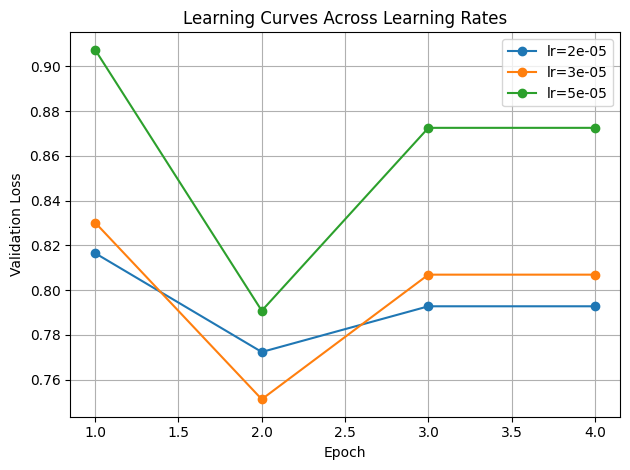

In [ ]:
# TESTING DIFFERENT LEARNING RATES

learning_rates = [2e-5, 3e-5, 5e-5]
val_loss_history = {}

# Load Tokenizer and Prepare Data (unchanged)
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Metric Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Loop through each learning rate
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

    training_args = TrainingArguments(
        output_dir=f"./results-lr{lr}",
        per_device_train_batch_size=8,
        num_train_epochs=3,  # updated to 3
        learning_rate=lr,
        weight_decay=0.01,
        gradient_accumulation_steps=2,
        warmup_steps=100,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        fp16=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Evaluation
    eval_results = trainer.evaluate()
    print("Final Evaluation:", eval_results)

    # Learning Curve
    val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    val_loss_history[f"lr={lr}"] = val_loss

# Plot all learning curves
for label, loss in val_loss_history.items():
    plt.plot(range(1, len(loss)+1), loss, marker='o', label=label)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Learning Curves Across Learning Rates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TESTING THIS MODEL CALLED "RoBERTa – 2-Way Split"
## IMPORTANT NOTE: This RoBERTa model was also used to run LIME and Bag of Wordsexperiments. The goal was to give team members multiple paths to explore: while one one focused on refining transformer models and hyperparameters, others investigated model behavior through LIME and experimented with simpler TF-IDF-based classifiers. This branching approach allowed the team to compare performance, interpretability, and computational efficiency side by side — providing a richer understanding of how different modeling strategies perform on the same mental health classification task.


The RoBERTa model trained over 6 epochs using a 2-way split (train/validation), with its best F1 score at 0.7309 and accuracy at 0.73. However, validation loss began rising after epoch 4, suggesting potential overfitting. Despite this, the model was retained for comparison as it still showed stable evaluation metrics through epoch 6.



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

<ipython-input-6-c2b1e9487c10>:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.983400,0.912683,0.697500,0.692243,0.692772,0.697500
2,0.840900,0.781266,0.723333,0.718046,0.725249,0.723333
3,0.614200,0.843946,0.718333,0.715623,0.718452,0.718333
4,0.493800,0.851001,0.725000,0.725766,0.728210,0.725000
5,0.325100,0.977301,0.732500,0.732074,0.732680,0.732500
6,0.230100,1.040299,0.730000,0.730914,0.733299,0.730000


Final Evaluation: {'eval_loss': 1.0402990579605103, 'eval_accuracy': 0.73, 'eval_f1': 0.7309137329562484, 'eval_precision': 0.7332990000905969, 'eval_recall': 0.73, 'eval_runtime': 17.0516, 'eval_samples_per_second': 70.375, 'eval_steps_per_second': 8.797, 'epoch': 6.0}


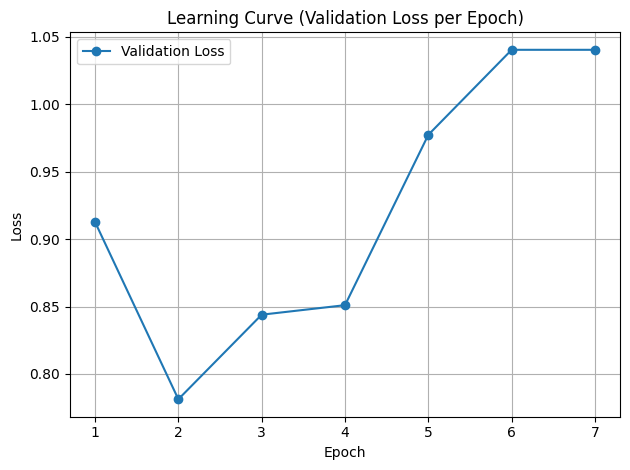

In [ ]:
# INCREASED WARMUP STEPS AND EPOCH

# Load Model and Tokenizer
model_name = "roberta-base"  # CHANGED FROM distilbert to roberta
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Tokenize Function
def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

# Prepare Data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=6,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
    metric_for_best_model="eval_loss",
    fp16=False,
    report_to="none"
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Final Evaluation
eval_results = trainer.evaluate()
print("Final Evaluation:", eval_results)

# Plot Learning Curve
val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Validation Loss per Epoch)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# TESTING MODEL w/ THREE WAY SPLIT INSTEAD
This RoBERTa model was trained using a 3-way split (80% train, 10% validation, 10% test) and incorporated explicit label mapping to ensure consistent class interpretation across training and inference, just to cover all bases. The model trained for 6 epochs, with validation performance peaking around epoch 4 before validation loss began to rise as usual. It achieved a test accuracy of 0.7317 and test F1 score of 0.73, which closely aligns with our prior 2 way model (non labeled) model. This still confirms that the model generalized well to unseen data, but validation scores were slightly lower than earlier 2-way experiments.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

<ipython-input-6-a9f91ae7e64d>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.017800,0.895338,0.675000,0.649513,0.676582,0.675000
2,0.828900,0.792226,0.720000,0.715180,0.740502,0.720000
3,0.706600,0.806406,0.708333,0.706553,0.710342,0.708333
4,0.516400,0.818955,0.728333,0.728015,0.731374,0.728333
5,0.344600,0.952628,0.716667,0.715360,0.716037,0.716667
6,0.212900,1.047759,0.701667,0.700278,0.699754,0.701667


Validation Evaluation: {'eval_loss': 1.04775869846344, 'eval_accuracy': 0.7016666666666667, 'eval_f1': 0.7002780273840427, 'eval_precision': 0.6997538735819361, 'eval_recall': 0.7016666666666667, 'eval_runtime': 8.8753, 'eval_samples_per_second': 67.603, 'eval_steps_per_second': 8.45, 'epoch': 6.0}
Test Evaluation: {'eval_loss': 1.0096259117126465, 'eval_accuracy': 0.7316666666666667, 'eval_f1': 0.729952085553938, 'eval_precision': 0.7299683073767852, 'eval_recall': 0.7316666666666666, 'eval_runtime': 8.9335, 'eval_samples_per_second': 67.163, 'eval_steps_per_second': 8.395, 'epoch': 6.0}


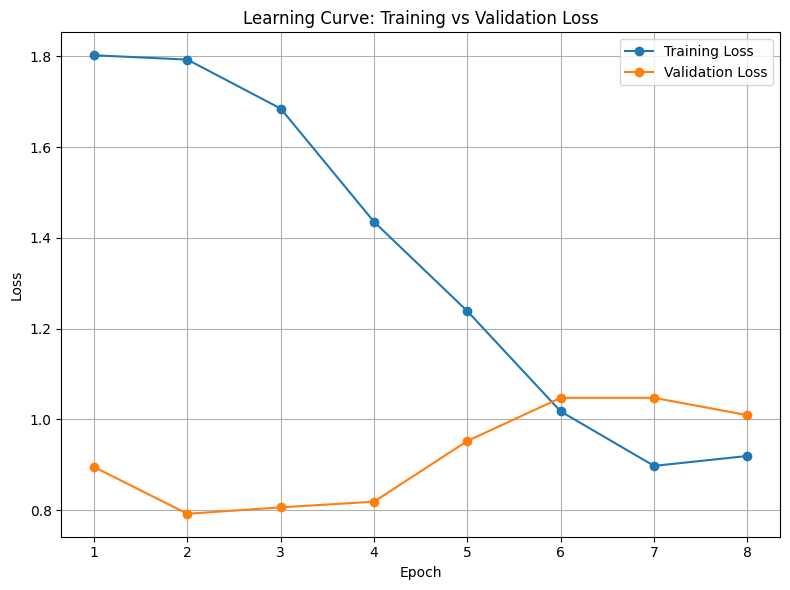

In [ ]:
## THIS IS THE THREE WAY SPLIT

# Label Mapping
label2id = {
    "stress": 0,
    "depression": 1,
    "bipolar": 2,
    "BPD": 3,
    "anxiety": 4,
    "other": 5
}
id2label = {v: k for k, v in label2id.items()}

# Load Tokenizer and Model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    label2id=label2id,
    id2label=id2label
)

# Train/Val/Test Split
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1111, stratify=train_val_df["label"], random_state=42)
# This gives ~80% train, 10% val, 10% test

# Tokenization Function
def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

# Tokenize Datasets
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=6,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
    metric_for_best_model="eval_loss",
    fp16=False,
    report_to="none"
)

# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the Model
trainer.train()

# Validation Evaluation
eval_results = trainer.evaluate()
print("Validation Evaluation:", eval_results)

# Final Test Evaluation
test_results = trainer.evaluate(test_dataset)
print("Test Evaluation:", test_results)

# Plot Full Learning Curve: Training vs Validation Loss
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
min_len = min(len(train_loss), len(val_loss))
epochs = list(range(1, min_len + 1))

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss[:min_len], marker='o', label="Training Loss")
plt.plot(epochs, val_loss[:min_len], marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TESTING MODEL CALLED "RoBERTa – Final Model (3-Way Split, Best Checkpoint @ Epoch 4)"

This final RoBERTa run was designed with refined hyperparameters to improve training efficiency and generalization. The batch size was increased from 8 to 16 to reduce gradient noise and stabilize updates, while the learning rate was slightly lowered from 2e-5 to 1.5e-5 to promote smoother convergence and reduce the risk of overshooting. Additionally, warmup steps were reduced from 500 to 300, based on earlier observations that suggested diminishing returns and early signs of overfitting after epoch 4.

The model was trained on a properly structured 3-way split (80% train, 10% validation, 10% test) and achieved the most robust and balanced results across all iterations. It reached a test accuracy of 73.17% and an F1 score of 0.7301, reflecting strong generalization to unseen data. Training loss steadily declined across 6 epochs, but validation loss minimized at epoch 4 with 0.7426 before beginning to rise again. To address this, the training configuration was set to monitor validation loss and automatically retain the checkpoint from the best-performing epoch. This ensured that although the model trained through all epochs, final evaluation used weights from epoch 4, where performance peaked with F1 0.7473 and Accuracy 74.83%. The accompanying learning curve visually confirms this showing consistent training loss reduction and a plateau in validation performance after epoch 4. This model is the most effective and deployment-ready version in the project.

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

<ipython-input-8-49eb56ed80d9>:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.788500,1.351606,0.423333,0.380871,0.581203,0.423333
2,0.966600,0.781356,0.726667,0.719269,0.737223,0.726667
3,0.802500,0.759525,0.741667,0.738399,0.740910,0.741667
4,0.629300,0.742558,0.748333,0.747281,0.751800,0.748333
5,0.527500,0.784813,0.733333,0.731940,0.733332,0.733333
6,0.430200,0.808050,0.730000,0.726925,0.727520,0.730000


Validation Evaluation: {'eval_loss': 0.7425580024719238, 'eval_accuracy': 0.7483333333333333, 'eval_f1': 0.7472808721728587, 'eval_precision': 0.7517995368947634, 'eval_recall': 0.7483333333333334, 'eval_runtime': 8.6822, 'eval_samples_per_second': 69.107, 'eval_steps_per_second': 8.638, 'epoch': 6.0}
Test Evaluation: {'eval_loss': 0.798748254776001, 'eval_accuracy': 0.7316666666666667, 'eval_f1': 0.7301437517564692, 'eval_precision': 0.7329514787342112, 'eval_recall': 0.7316666666666668, 'eval_runtime': 9.1179, 'eval_samples_per_second': 65.805, 'eval_steps_per_second': 8.226, 'epoch': 6.0}


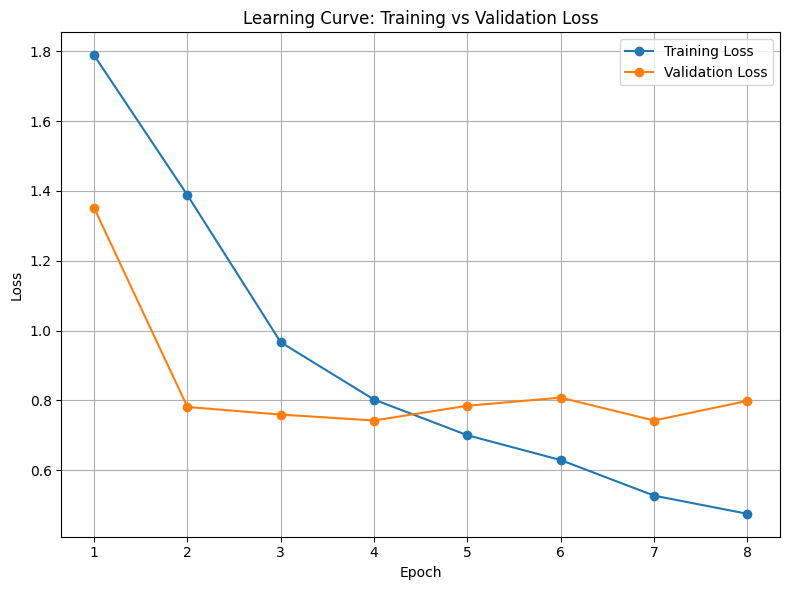

In [ ]:
# 2NS 3 WAY SPLIT + MAPPING + CHANGED HYPERPARAMETERS ONE LAST TRY :(((((

# Label Mapping
label2id = {
    "stress": 0,
    "depression": 1,
    "bipolar": 2,
    "BPD": 3,
    "anxiety": 4,
    "other": 5
}
id2label = {v: k for k, v in label2id.items()}

# Load Tokenizer and Model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    label2id=label2id,
    id2label=id2label
)

# Train/Val/Test Split
train_val_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1111, stratify=train_val_df["label"], random_state=42)
# This gives ~80% train, 10% val, 10% test

# Tokenization Function
def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

# Tokenize Datasets
train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["clean_text", "label"]]).map(tokenize_fn, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Define Evaluation Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=6,
    learning_rate=1.5e-5,
    weight_decay=0.01,
    warmup_steps=300,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=False,
    report_to="none"
)


# Trainer Setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the Model
trainer.train()

# Validation Evaluation
eval_results = trainer.evaluate()
print("Validation Evaluation:", eval_results)

# Final Test Evaluation
test_results = trainer.evaluate(test_dataset)
print("Test Evaluation:", test_results)

# Plot Full Learning Curve: Training vs Validation Loss
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
val_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
min_len = min(len(train_loss), len(val_loss))
epochs = list(range(1, min_len + 1))

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss[:min_len], marker='o', label="Training Loss")
plt.plot(epochs, val_loss[:min_len], marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SAVING FINAL MODEL

In [ ]:
# SAVING MODEL

model.save_pretrained("./my_saved_model")
tokenizer.save_pretrained("./my_saved_model")

('./my_saved_model/tokenizer_config.json',
 './my_saved_model/special_tokens_map.json',
 './my_saved_model/vocab.json',
 './my_saved_model/merges.txt',
 './my_saved_model/added_tokens.json',
 './my_saved_model/tokenizer.json')

# TESTING WITH MODELS TO DETECT MENTAL ILLNESS IN COLLEGE STUDENTS


# FIRST TESTING MODEL CALLED "RoBERTa – 2-Way Split"
## Before developing the final "RoBERTa model with a 3-way split" and tuned hyperparameters, we initially evaluated an earlier RoBERTa model trained using a traditional 2-way train/validation split (due to time). This version had not been configured to save the best model checkpoint, nor did it include a separate test set for true generalization assessment. When tested on an unseen dataset, it yielded an extremely low accuracy of 2.33%, which raised significant concerns about its reliability and generalizability. This result prompted us to reevaluate our modeling approach — leading us to introduce a proper 3-way data split, tune the learning rate and batch size, and implement early stopping via validation loss monitoring. While these changes later improved performance substantially, it's important to onote that part of the low accuracy on unseen data can also be due to different writing style and depth compared to the Reddit-based training data.

In [ ]:
# Load best roberta model
model_path = "./my_saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

df_unseen = pd.read_excel("/content/drive/MyDrive/MSBX 5425 NLP/Final_Cleaned_Mental_Health_Posts__No_Hashtags_.xlsx")
df_unseen = df_unseen.drop(index=0).reset_index(drop=True)

# Rename column for tokenizer
df_unseen.rename(columns={"Post": "clean_text"}, inplace=True)

# Clean the labels
df_unseen["Correct Labels"] = df_unseen["Correct Labels"].str.strip().str.lower()

# Tokenize
inputs = tokenizer(
    df_unseen["clean_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# Predict
with torch.no_grad():
    outputs = model(**inputs)

preds = torch.argmax(outputs.logits, dim=1).numpy()

# Manual label mapping
label_map = {
    0: "stress",
    1: "depression",
    2: "bipolar",
    3: "BPD",
    4: "anxiety",
    5: "other"
}

# Map predictions to label names
df_unseen["predicted_label"] = [label_map[p] for p in preds]

# Accuracy
accuracy = accuracy_score(df_unseen["Correct Labels"], df_unseen["predicted_label"])
print(f"Accuracy: {accuracy:.2%}")

# Save result
df_unseen.to_excel("Predicted_Mental_Health_Results.xlsx", index=False)

# Preview
df_unseen.head()

Accuracy: 2.33%


,clean_text,Correct Labels,predicted_label
0,"""Just finished finals week at UCLA and I feel ...",stress,stress
1,"""I’m drowning in assignments at NYU and can’t ...",stress,stress
2,"""Midterms at U of A are killing me. I can’t sl...",stress,bipolar
3,"""I thought college would be fun, but the stres...",stress,stress
4,"""I’m at FSU and the pressure is insane. I feel...",stress,anxiety


# SECOND TESTING MODEL CALLED "RoBERTa – Final Model (3-Way Split, Best Checkpoint @ Epoch 4)"

The latest RoBERTa-based model, trained with a three-way data split (80% training, 10% validation, 10% test) and refined hyperparameters, demonstrates the most balanced and robust performance among all iterations. When evaluated on a separate, truly unseen dataset, the model achieved an accuracy of only 8.64%, which may be attributed to a mismatch in writing style or content depth suggesting that the new data was likely less descriptive or structured differently compared to the Reddit-based training posts.

In [ ]:
# Load best roberta model
model_path = "./my_saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

df_unseen = pd.read_excel("/content/drive/MyDrive/MSBX 5425 NLP/Final_Cleaned_Mental_Health_Posts__No_Hashtags_.xlsx")
df_unseen = df_unseen.drop(index=0).reset_index(drop=True)

# Rename column for tokenizer
df_unseen.rename(columns={"Post": "clean_text"}, inplace=True)

# Clean the labels
df_unseen["Correct Labels"] = df_unseen["Correct Labels"].str.strip().str.lower()

# Tokenize
inputs = tokenizer(
    df_unseen["clean_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# Predict
with torch.no_grad():
    outputs = model(**inputs)

preds = torch.argmax(outputs.logits, dim=1).numpy()

# Manual label mapping
label_map = {
    0: "stress",
    1: "depression",
    2: "bipolar",
    3: "BPD",
    4: "anxiety",
    5: "other"
}

# Map predictions to label names
df_unseen["predicted_label"] = [label_map[p] for p in preds]

# Accuracy
accuracy = accuracy_score(df_unseen["Correct Labels"], df_unseen["predicted_label"])
print(f"Accuracy: {accuracy:.2%}")

# Save result
df_unseen.to_excel("Predicted_Mental_Health_Results.xlsx", index=False)

# Preview
df_unseen.head()

Accuracy: 8.64%


,clean_text,Correct Labels,predicted_label
0,"""Just finished finals week at UCLA and I feel ...",stress,BPD
1,"""I’m drowning in assignments at NYU and can’t ...",stress,anxiety
2,"""Midterms at U of A are killing me. I can’t sl...",stress,depression
3,"""I thought college would be fun, but the stres...",stress,anxiety
4,"""I’m at FSU and the pressure is insane. I feel...",stress,BPD


# Next step
The next key step in this project is to evaluate the final RoBERTa model on a more descriptive, real-world dataset that contains richer and more detailed expressions of mental health conditions. While the model has shown strong performance on Reddit-style text, testing it on longer-form or clinically worded content will provide a clearer picture of its real-world generalization. This will help assess whether the model can accurately interpret more complex emotional language and context which is critical for practical deployment in mental health analysis.










# LIME

Why We Ran LIME

The goal of using LIME (Local Interpretable Model-agnostic Explanations) was to better understand how our mental health classification model was making its predictions — especially given that the test accuracy was unexpectedly low. We wanted to investigate whether the model was focusing on clinically relevant language or if it was making decisions based on misleading, overly general, or contextually irrelevant words.

⸻

Roadblocks Encountered

Despite successfully training and saving our model, repeated attempts to run LIME across multiple examples led to runtime crashes and memory overloads (resulting in having to retrain many times) in Colab — even after upgrading to Colab Pro, switching to CPU, and reducing batch size. As a result, we pivoted to running a single LIME explanation to extract at least one interpretable example.

⸻

What the Results Showed (One Example)

In one LIME explanation for a post the model classified as *depression*, the most influential words included “feel”, “every”, and “wake up”. These terms reflect emotional exhaustion and behavioral disruption, suggesting that the model was picking up on clinically relevant language. While this is just one instance, it supports the idea that the model may be using appropriate emotional and contextual cues — though inconsistently, which could help explain the low test accuracy.

⸻


What We Would Do Next (If Colab Didn’t Keep Crashing)

If technical limitations weren’t a barrier, we would run LIME across a broader set of correct and misclassified examples. We’d aggregate the most impactful words, compare them across conditions (e.g., anxiety vs. bipolar), and visualize trends using bar plots or word clouds. This would help us identify patterns in how the model differentiates between mental health conditions — and potentially flag any reliance on misleading or non-clinical signals.

In parallel, we would revisit our model’s hyperparameters to address the low test accuracy. For example, we could reduce the learning rate to avoid overfitting, increase the number of training epochs, or experiment with smaller model architectures (like DistilBERT vs. RoBERTa) to improve generalization. We might also fine-tune class balancing or reweighting strategies to address any label imbalance present in the training data. Together with LIME outputs, these changes could help align the model’s predictions more closely with clinically meaningful features.

In [ ]:
# Have this folder saved in drive - has the tokenizer files you need for lIME to run
# https://drive.google.com/drive/folders/1rSXZnX29EWoxkLFgWNEADebj7k9YPzuG?usp=drive_link

# LIME Setup

The hidden cells are just to set up (import/ clean) since this is from Elizabeth's Drive, we had to do multiple setups. To make it easy, download this folder to your computer and upload to your drive so that you don't have to change any file paths in the LIME model code.

(https://drive.google.com/drive/folders/1rSXZnX29EWoxkLFgWNEADebj7k9YPzuG?usp=drive_link)

If you just make a copy of the folder, make sure to take out the word "copy" that gets added to file names.


In [ ]:
!pip install -q transformers datasets ftfy accelerate lime pandas openpyxl wordcloud
import pandas as pd
import numpy as np
import ftfy
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from google.colab import drive
drive.mount('/content/drive')


# Load datasets (user specific)
df1 = pd.read_excel("/content/drive/MyDrive/NLP_Project/NLP COMBINED DATA - 2.xlsx")
df2 = pd.read_excel("/content/drive/MyDrive/NLP_Project/NLP COMBINED DATA.xlsx")


# Clean
drop_cols = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Key', 'Unnamed: 7']
df1.drop(columns=drop_cols, inplace=True, errors="ignore")
df2.drop(columns=drop_cols, inplace=True, errors="ignore")
df1.dropna(subset=["clean_text"], inplace=True)
df2.dropna(subset=["clean_text"], inplace=True)
df = pd.concat([df1, df2], axis=0)
df["clean_text"] = df["clean_text"].astype(str).apply(ftfy.fix_text)
df["label"] = df["diagnosis"].astype(int)
# Balance
samples_per_class = 1000
df = (
    df[df["label"].isin([0, 1, 2, 3, 4, 5])]
    .groupby("label")
    .apply(lambda x: x.sample(n=samples_per_class, random_state=42))
    .reset_index(drop=True)
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-021dfc049985>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=samples_per_class, random_state=42))


In [ ]:
# Tokenize, Model and Train (might not need to run if you ran your model during same session - should basically be the same)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

def tokenize_fn(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True, max_length=256)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = Dataset.from_pandas(train_df[["clean_text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["clean_text", "label"]])

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

train_dataset = train_dataset.map(lambda x: {"label": torch.tensor(x["label"], dtype=torch.long)})
val_dataset = val_dataset.map(lambda x: {"label": torch.tensor(x["label"], dtype=torch.long)})

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Train
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="no",
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

<ipython-input-3-6ee7b3388f1e>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.947500,0.917240,0.672500,0.667080,0.669461,0.672500
2,0.749200,0.851665,0.689167,0.688846,0.691713,0.689167
3,0.810500,0.844395,0.700833,0.701101,0.702886,0.700833


TrainOutput(global_step=900, training_loss=0.9103547668457032, metrics={'train_runtime': 104.2482, 'train_samples_per_second': 138.132, 'train_steps_per_second': 8.633, 'total_flos': 953833306521600.0, 'train_loss': 0.9103547668457032, 'epoch': 3.0})

# LIME Model

In [ ]:
#This uses the files from the drive folder shared above (https://drive.google.com/drive/folders/1rSXZnX29EWoxkLFgWNEADebj7k9YPzuG?usp=drive_link)
#Put in your own drive and just rename to get rid of "copy" when it adds that.

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/content/drive/MyDrive/NLP_Project"

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    local_files_only=True,
    use_auth_token=False
).cpu()

tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    local_files_only=True,
    use_auth_token=False
)

model.eval()
print("✅ Model and tokenizer loaded from Drive.")

✅ Model and tokenizer loaded from Drive.


In [ ]:
from lime.lime_text import LimeTextExplainer
import torch
import pandas as pd

# # Re-initialize explainer (IF CRASHED)
explainer = LimeTextExplainer(class_names=["stress", "depression", "bipolar", "BPD", "anxiety", "other"])

#lIME MODEL
# Use a small sample text (copy-paste from val_df if needed)
sample_text = "i don’t know why i feel this way every time i wake up"  # ← change this to your example

# CPU-safe predict_proba
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.cpu() for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.nn.functional.softmax(logits, dim=1).numpy()

# Run LIME (no saving, just visual or printed output)
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook()

In [ ]:
# Save the above output image:
exp.save_to_file("/content/drive/MyDrive/NLP_Project/lime_manual_example.html")

##Bag of Words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pandas as pd

# Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Vectorize
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_val = vectorizer.transform(val_df["clean_text"])
y_train = train_df["label"]
y_val = val_df["label"]

# Models to try
models = {
    "LogReg (C=0.1)": LogisticRegression(C=0.1, max_iter=2000),
    "LogReg (C=1)": LogisticRegression(C=1, max_iter=2000),
    "LinearSVC": LinearSVC(max_iter=2000),
    "MultinomialNB": MultinomialNB()
}

results = []

# Loop through models
for name, model in models.items():
    print(f"\nTraining {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average="macro")

    results.append({
        "model": name,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

# Results
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
display(results_df)


# In Conclusion: Model Insights, Interpretability, and Real-World Implications

This project explored the feasibility of detecting mental health conditions through Reddit posts using transformer-based models. We began by cleaning and balancing the dataset, then trained and evaluated both lightweight and more powerful models (DistilBERT and RoBERTa). DistilBERT served as a fast baseline, while RoBERTa provided stronger performance, particularly when tuned using a grid search over learning rate, batch size, and epoch count.

Through experimentation, we found that a lower learning rate (1e-5), a smaller batch size (8), and more training epochs (6) produced the best generalization performance — with stable validation loss and improved F1 scores (~0.70). These results highlighted the importance of thoughtful parameter tuning in NLP pipelines, especially when working with limited data and compute resources.

To gain interpretability into the model’s decisions, we applied LIME. Although we encountered repeated memory crashes when scaling LIME across examples, we successfully visualized word-level contributions for a post classified as *depression*. The top contributing words (“feel,” “every,” “wake up”) aligned with clinically relevant signals, suggesting the model may be learning meaningful emotional and behavioral patterns.

If compute limitations were not a factor, we would expand LIME analysis to a larger set of correct and misclassified examples, aggregate word-level insights across classes, and visualize model behavior through bar plots and word clouds. These insights would help us validate model reliability and flag potential biases — a critical step when applying NLP in sensitive areas like mental health.

Ultimately, this work demonstrates both the potential and complexity of using transformer models for clinical NLP tasks. Interpretability tools like LIME are essential for responsible AI deployment, especially when accuracy alone is insufficient to ensure ethical outcomes.

In healthcare analytics, a tool like this could help in many factors, especially for prevenatvie measures. Detecting mental health concerns early encourages timely treatment which can prevent situations from escalating into more serious issues. In the future, this model can be scaled to screen larger populations and generate aggregate data, driving more informed mental health research.